## Setup

In [1]:
! pip install neuralogic
from neuralogic.core import Template, R, V
from neuralogic.dataset import Dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.6/465.6 KB 22.8 MB/s eta 0:00:00


/usr/local/lib/python3.8/dist-packages/neuralogic/core/builder/builder.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [24]:
template = Template()

# GNN-like graph propagation
template +=  R.layer_1(V.X) <= (R.bond(V.X, V.Y, V.B))

### Dataset definition

In [25]:
train_dataset = Dataset()
train_dataset.add_example(
    [
        R.o(1), R.h(2), R.h(3), # water
        R.bond(1, 2, 10), R.bond(2,1,10),
      R.bond(1, 3, 11), R.bond(3,1,11),
        R.b_1(10), R.b_1(11)
    ],
)
train_dataset.add_example(
    [
        R.o(1), R.h(2), R.h(3), R.h(4), R.h(5), R.c(6), # methanol
        R.bond(1, 2, 10), R.bond(2,1,10),
      R.bond(6, 3, 11), R.bond(3,6,11),
      R.bond(6, 4, 12), R.bond(4,6,12),
      R.bond(6, 5, 13), R.bond(5,6,13),
     R.bond(1, 6, 14), R.bond(6, 1, 14),
        R.b_1(10), R.b_1(11), R.b_1(12), R.b_1(13), R.b_1(14)
    ],
)

## Bonding rules

In [26]:
## check bonding rules if working well
template += R.single_bonded(V.X, V.Y) <= (R.bond(V.X, V.Y, V.B), R.b_1(V.B))
template += R.double_bonded(V.X, V.Y) <= (R.bond(V.X, V.Y, V.B), R.b_2(V.B))
template += R.double_bonded(V.X, V.Y) <= (R.bond(V.X, V.Y, V.B), R.b_2(V.B))
template += R.triple_bonded(V.X, V.Y) <= (R.bond(V.Y, V.X, V.B), R.b_3(V.B))
template += R.aromatic_bonded(V.X, V.Y) <= (R.bond(V.X, V.Y, V.B), R.b_7(V.B)) # maybe also 4, 5 - contained on furan ring both on same oxygen

## Saturation

In [27]:
from neuralogic.core import Aggregation

template += R.saturated(V.X) <= (R.c(V.X),
                                 R.single_bonded(V.X, V.Y1),
                                 R.single_bonded(V.X, V.Y2),
                                 R.single_bonded(V.X, V.Y3),
                                 R.single_bonded(V.X, V.Y4),
                                 R.special.alldiff(...)) # with alldiff it doesn't work
template += (R.saturated <= (R.saturated(V.X))) | [Aggregation.MIN]

Alcohol

In [28]:
'''template += R.alcohol(V.Mol) <= (R.contains(V.Mol, V.C), R.alcoholic(V.C))
template += R.alcoholic(V.C) <= (R.saturated(V.C), R.o(V.O), R.h(V.H), 
                                 R.single_bonded(V.C, V.O),
                                 R.single_bonded(V.O, V.H))'''

template += R.alcoholic <= (R.saturated(V.C), R.o(V.O), R.h(V.H), 
                            R.single_bonded(V.C, V.O),
                            R.single_bonded(V.O, V.H))

Carbonyl

In [ ]:
# carbonyl group contains a carbon double bonded with oxygen
template += R.carbonyl(V.Mol) <= (R.contains(V.Mol, V.C), R.contains(V.Mol, V.O), R.carbonyl_group(V.O, V.C))
template += R.carbonyl_group(V.C, V.O) <= (R.c(V.C), R.o(V.O), R.double_bonded(V.O, V.C))
template += R.carbonyl_group(V.C, V.O, V.R1, V.R2) <= (R.c(V.C), R.o(V.O), R.double_bonded(V.O, V.C), R.single_bonded(V.C, V.R1), R.single_bonded(V.C, V.R2))

Ketone

In [ ]:
template += R.ketone(V.Mol) <= (R.contains(V.Mol, V.C), 
                                R.carbonyl_group(V.C, _, V.R1, V.R2),
                                R.c(V.R1), R.c(V.R2))

Aldehyde

In [ ]:
template += R.aldehyde(V.Mol) <= (R.contains(V.Mol, V.C), 
                                  R.carbonyl_group(V.C, _, V.R, V.H),
                                  R.c(V.R), R.h(V.H))

Acylhalide

In [ ]:
template += R.acyl_fluoride(V.Mol) <= (R.contains(V.Mol, V.C), 
                                       R.carbonyl_group(V.C, _, V.R, V.X),
                                       R.c(V.R), R.f(V.X))

template += R.acyl_chloride(V.Mol) <= (R.contains(V.Mol, V.C), 
                                       R.carbonyl_group(V.C, _, V.R, V.X),
                                       R.c(V.R), R.cl(V.X))

template += R.acyl_bromide(V.Mol) <= (R.contains(V.Mol, V.C), 
                                      R.carbonyl_group(V.C, _, V.R, V.X),
                                      R.c(V.R), R.br(V.X))

template += R.acyl_iodide(V.Mol) <= (R.contains(V.Mol, V.C), 
                                     R.carbonyl_group(V.C, _, V.R, V.X),
                                     R.c(V.R), R.i(V.X))


template += R.acyl_halide(V.Mol) <= R.acyl_fluoride(V.Mol)
template += R.acyl_halide(V.Mol) <= R.acyl_chloride(V.Mol)
template += R.acyl_halide(V.Mol) <= R.acyl_bromide(V.Mol)
template += R.acyl_halide(V.Mol) <= R.acyl_iodide(V.Mol)

Carboxylic acid

In [ ]:
template += R.carboxylic_acid(V.Mol) <= (R.contains(V.Mol, V.C), R.carbonyl_group(V.C, _, V.R, V.O),
                                R.c(V.R), R.o(V.O),
                                R.h(V.H), R.single_bonded(V.O, V.H))

Carboxylic acid anhydrides

In [ ]:
template += R.carboxylic_acid_anhydride(V.Mol) <= (R.contains(V.Mol, V.C1), R.contains(V.Mol, V.C1),
                                R.carbonyl_group(V.C1, _, V.O12, _),
                                R.o(V.O12),
                                R.carbonyl_group(V.C2, _, V.O12, _))

Ester

In [ ]:
template += R.ester(V.Mol) <= (R.contains(V.Mol, V.C), R.carbonyl_group(V.C, _, V.R, V.O),
                                R.c(V.R), R.o(V.O),
                                R.h(V.H), R.single_bonded(V.O, V.H))

template += R.carbonate_ester(V.Mol) <= (R.contains(V.Mol, V.C), R.carbonyl_group(V.C, _, V.O1, V.O2),
                                R.o(V.O1), R.o(V.O2),
                                
                                R.c(V.R1), R.single_bonded(V.R1, V.O1),
                                R.c(V.R2), R.single_bonded(V.O2, V.R2))

Ether

In [ ]:
template += R.ether(V.Mol) <= (R.contains(V.Mol, V.C), R.c(V.C), 
                                R.o(V.O), R.c(V.R), 
                                R.single_bonded(V.C, V.O),
                                R.single_bonded(V.O, V.R))



Peroxyde

In [ ]:
# peroxyde
template += R.peroxyde(V.Mol) <= (R.contains(V.Mol, V.C), R.c(V.C), # or saturated?
                                  R.o(V.O1), R.o(V.O2), R.c(V.R), 
                                  R.single_bonded(V.C, V.O1),
                                  R.single_bonded(V.O1, V.O2),
                                  R.single_bonded(V.O2, V.R))

# hydroperoxyde
template += R.hydroperoxyde(V.Mol) <= (R.contains(V.Mol, V.C), R.c(V.C), # or saturated?
                                       R.o(V.O1), R.o(V.O2), R.h(V.H), 
                                       R.single_bonded(V.C, V.O1),
                                       R.single_bonded(V.O1, V.O2),
                                       R.single_bonded(V.O2, V.H))

## Predicition

layer_1(X) :- bond(X, Y, B).
single_bonded(X, Y) :- bond(X, Y, B), b_1(B).
double_bonded(X, Y) :- bond(X, Y, B), b_2(B).
double_bonded(X, Y) :- bond(X, Y, B), b_2(B).
triple_bonded(X, Y) :- bond(Y, X, B), b_3(B).
aromatic_bonded(X, Y) :- bond(X, Y, B), b_7(B).
saturated(X) :- c(X), single_bonded(X, Y1), single_bonded(X, Y2), single_bonded(X, Y3), single_bonded(X, Y4), @alldiff(Y4, X, Y1, Y3, Y2).
saturated :- saturated(X). [aggregation=min]
alcoholic :- saturated(C), o(O), h(H), single_bonded(C, O), single_bonded(O, H).
{1} predict :- layer_1(X).
{1} predict :- alcoholic.


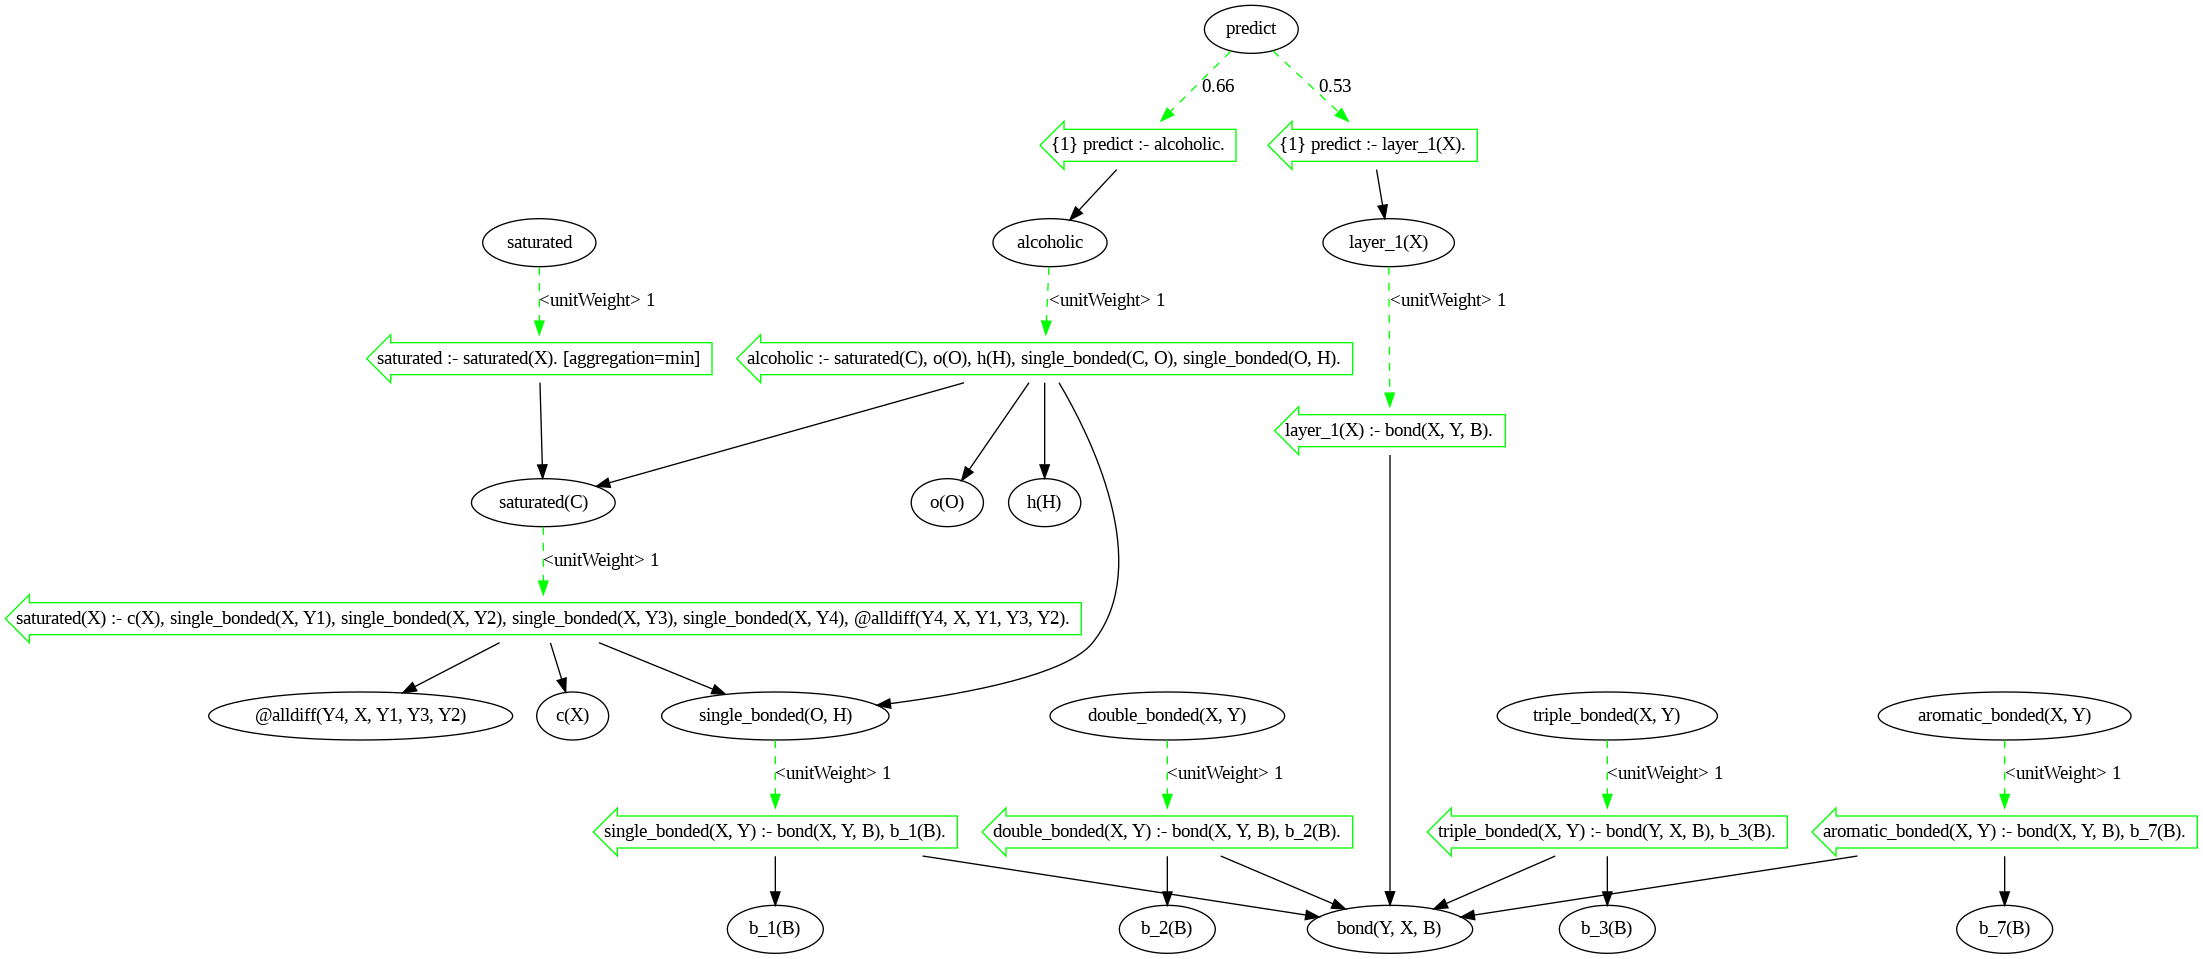

In [29]:
template += R.predict[1,] <= R.layer_1(V.X)
template += R.predict[1,] <= R.alcoholic

train_dataset.add_queries([
    R.predict[0],
    R.predict[1],
])
print(template)
template.draw()

## Training

In [30]:
from neuralogic.core import Settings
from neuralogic.nn.loss import MSE, CrossEntropy
from neuralogic.nn import get_evaluator
from neuralogic.optim import Adam

settings = Settings(optimizer=Adam(lr=0.1), epochs=100, error_function=CrossEntropy())
evaluator = get_evaluator(template, settings)

built_dataset = evaluator.build_dataset(train_dataset)

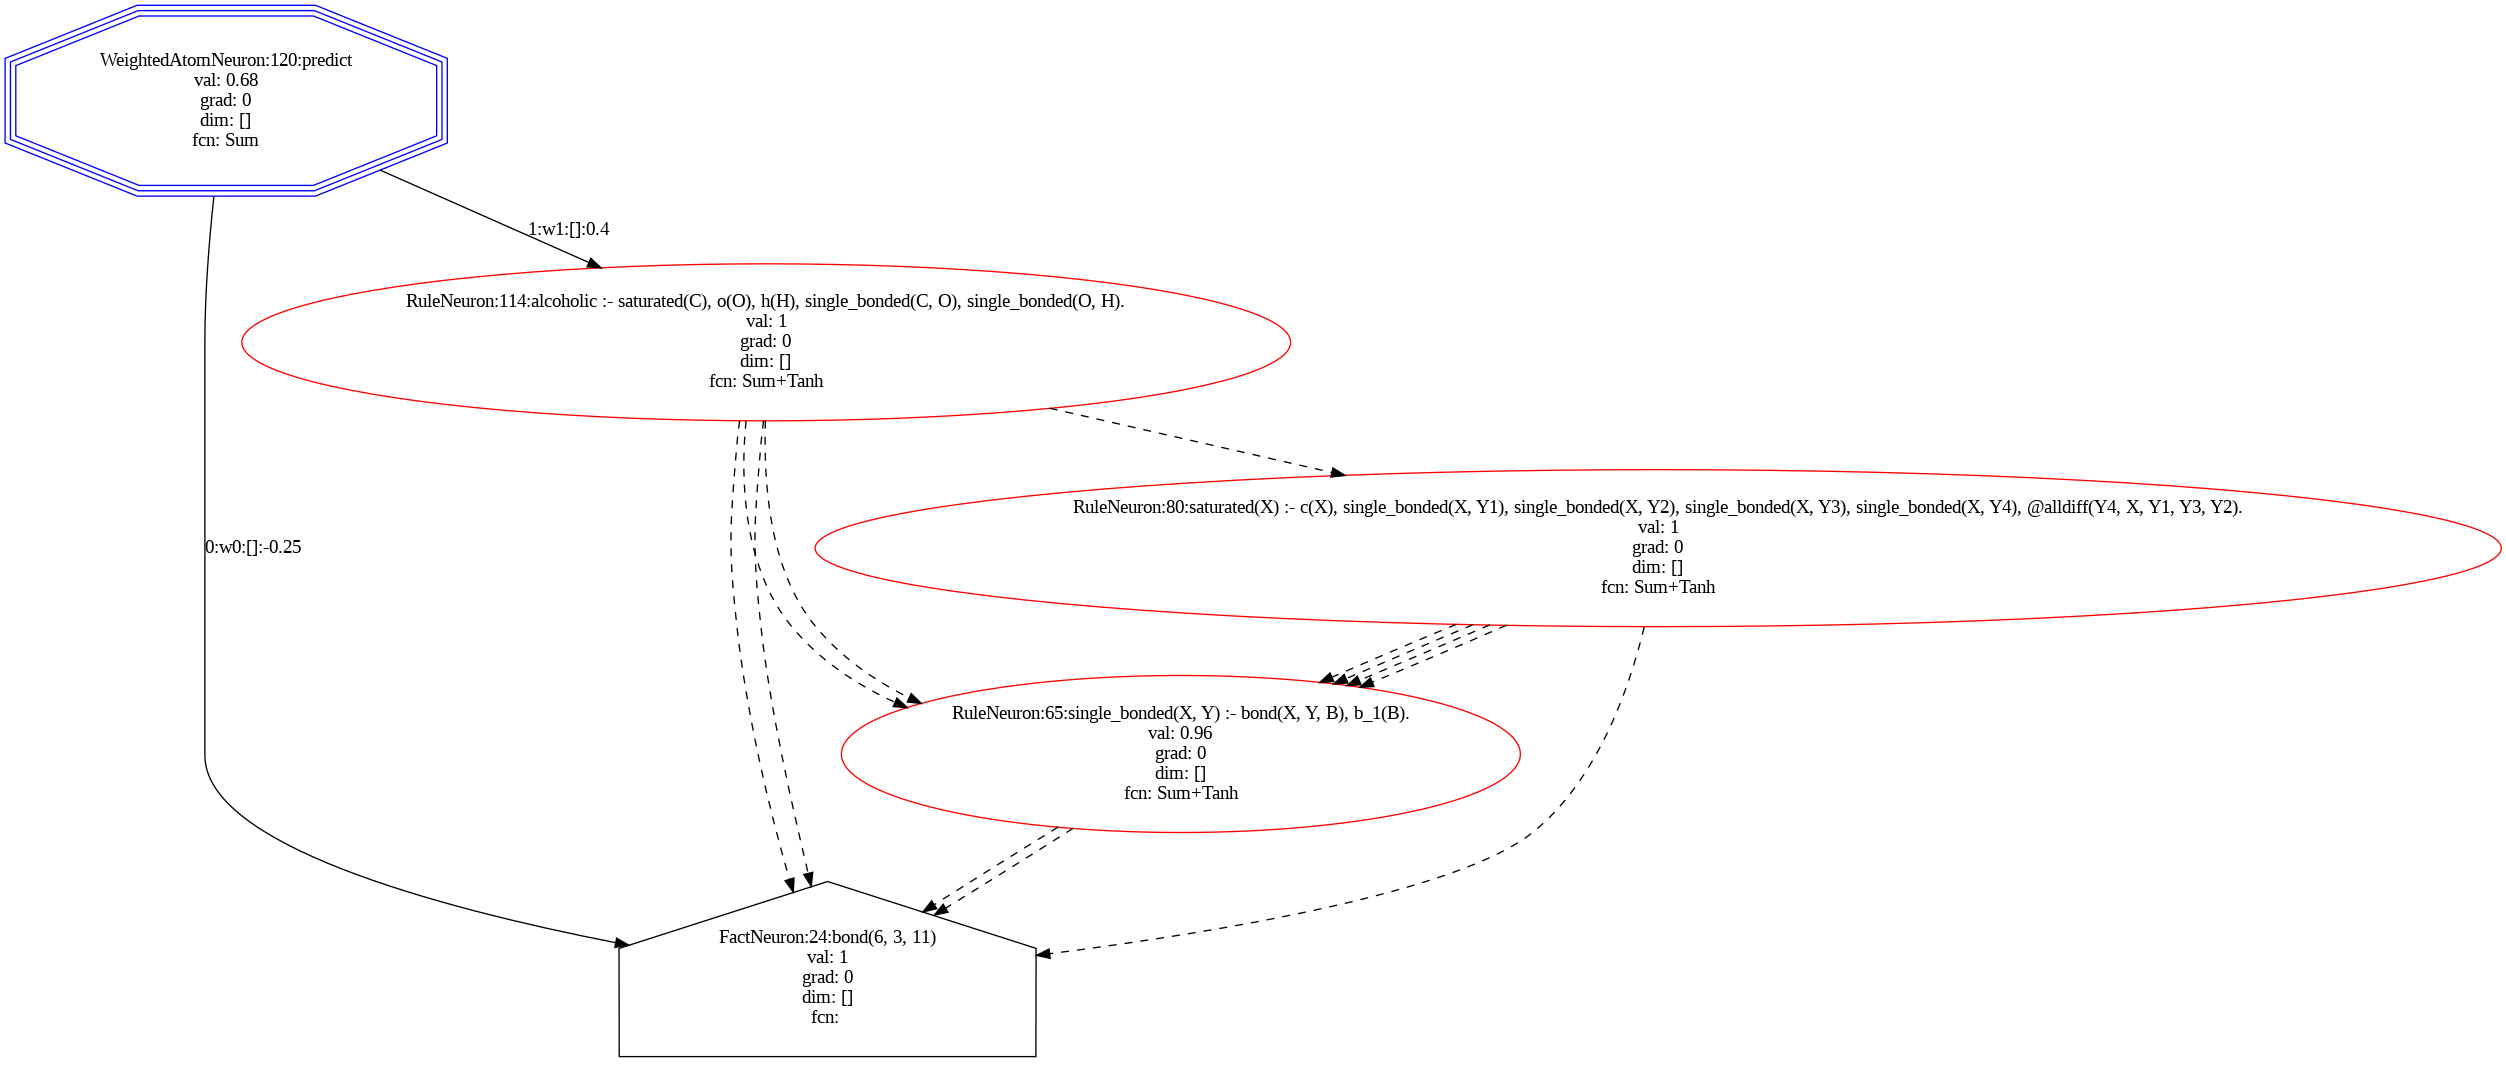

In [31]:
built_dataset[1].draw()

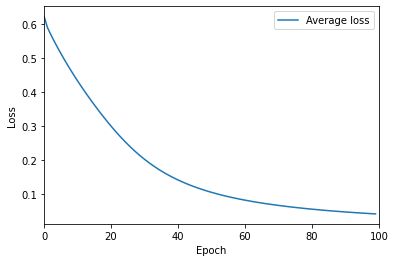

In [32]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

average_losses = []

for current_total_loss, number_of_samples in evaluator.train(built_dataset):
    clear_output(wait=True)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")

    plt.xlim(0, settings.epochs)

    average_losses.append(current_total_loss / number_of_samples)
    
    plt.plot(average_losses, label="Average loss")

    plt.legend()
    plt.pause(0.001)
    plt.show()

In [33]:
for sample, y_hat in zip(built_dataset.samples, evaluator.test(built_dataset)):
    print(f"Target: {sample.java_sample.target}, Predicted: {round(y_hat)} ({y_hat})")

Target: 0, Predicted: -3 (-2.8872985882193074)
Target: 1, Predicted: 4 (3.5873626677062873)
